In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
#Load the data.
train = pd.read_json("train.json")
test = pd.read_json("test.json")

In [3]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

In [5]:
angle = train['is_iceberg'].astype(np.float32)


In [6]:
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [7]:
X_band_1[0]

array([[-27.87836075, -27.15415955, -28.66861534, ..., -25.57348251,
        -26.48867416, -30.50701332],
       [-28.66852951, -27.8784008 , -27.50877571, ..., -26.4886322 ,
        -28.67156219, -31.5941658 ],
       [-28.66852951, -27.15415955, -25.86504173, ..., -27.1571064 ,
        -27.88139343, -32.83712387],
       ..., 
       [-29.09290504, -28.66916275, -30.50461197, ..., -30.0110054 ,
        -25.8685379 , -26.48926544],
       [-31.59168243, -27.87899208, -28.66920471, ..., -27.51227188,
        -26.81707382, -27.51235771],
       [-29.09290504, -26.81408119, -27.15479088, ..., -26.81703186,
        -27.8819828 , -28.26812744]], dtype=float32)

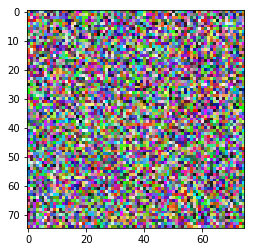

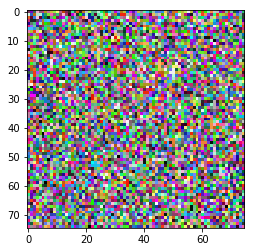

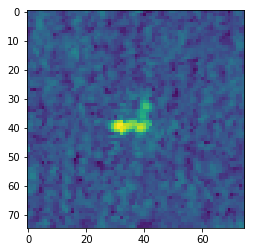

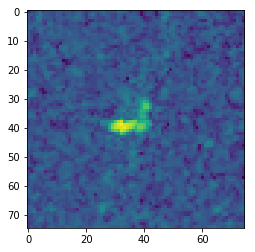

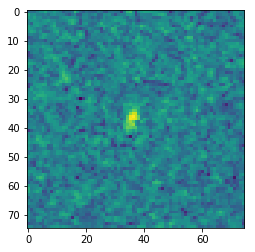

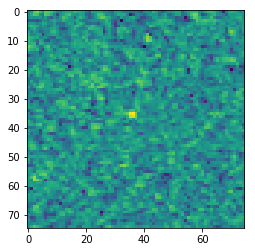

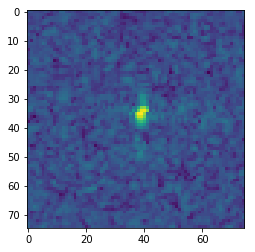

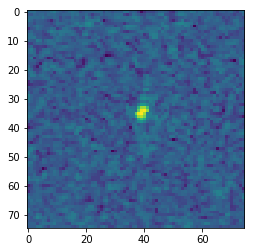

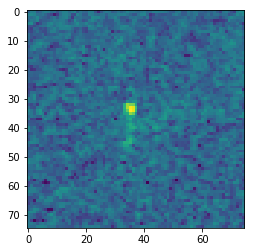

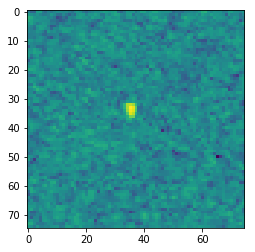

In [31]:
plt.imshow(X_band_1[1])
plt.figure()
plt.imshow(X_band_2[1])
plt.figure()
plt.imshow(X_band_1[2])
plt.figure()
plt.imshow(X_band_2[2])
plt.figure()
plt.imshow(X_band_1[3])
plt.figure()
plt.imshow(X_band_2[3])
plt.figure()
plt.imshow(X_band_1[4])
plt.figure()
plt.imshow(X_band_2[4])

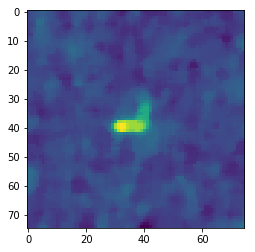

In [38]:
from scipy.ndimage.filters import median_filter
new = median_filter(X_band_1[1],5)
plt.imshow(new)

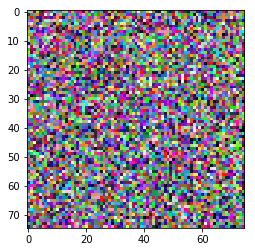

In [10]:
plt.imshow(X_train[0])

In [11]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.
/Users/yaqiongzhang/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [12]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [13]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

In [14]:
#Without denoising, core features.
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
__________

In [15]:
sum(train['is_iceberg'])


753

In [16]:
len(train['is_iceberg'])

1604

In [17]:
help (train_test_split)



Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float, int, or None (default is None)
        If float, should be between 0.0 and 1.0 and represent the
        proportion of the dataset to include in the test split. If
        int, represents the absolute number of test samples. If None,
        the value is automatically set to the complement of the train size.
    